Librerias

In [1]:
import pred_lgbm as pred
import funciones_lgbm as f_lgbm
import pandas as pd
import numpy as np
import matplotlib as plt

e:\PWC\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Entrenamos con una optimización de hiperparámetros utilizando optuna

In [2]:
def train_model_lgbm_optuna(data, test_size=0.2, random_state=42, n_trials=100, timeout=300):
    """
    Args:
        data: DataFrame completo con todas las columnas (incluyendo Salary)
        test_size: Proporción del conjunto de prueba
        random_state: Semilla aleatoria
        n_trials: Número máximo de pruebas de Optuna
        timeout: Tiempo límite en segundos para la optimización
    """
    print(f"\n🚀 Entrenando modelo LightGBM con Optuna + Features Estadísticos")
    print(f"   Trials: {n_trials}, Timeout: {timeout}s")
    
    # Importaciones necesarias
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import lightgbm as lgb
    import optuna
    import numpy as np
    import warnings
    
    # Silenciar warnings
    warnings.filterwarnings('ignore')
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # ============= PASO 1: PREPARAR GROUPING INFO =============
    print("📊 Paso 1: Preparando información de agrupación...")
    data_with_groups, grouping_info = f_lgbm.create_and_save_grouping_info(data)
    all_job_cats, all_seniority_cats = f_lgbm.get_all_categories(data_with_groups)
    
    print(f"   ✅ Grupos creados: Age_group, Exp_group")
    print(f"   ✅ Job categories: {len(all_job_cats)}")
    print(f"   ✅ Seniority levels: {len(all_seniority_cats)}")
    
    # ============= PASO 2: SEPARAR TARGET Y FEATURES =============
    
    print("🔄 Paso 2: Separando target y features...")
    
    X_data = data_with_groups.drop('Salary', axis=1)  # Variables disponibles en producción
    y = data_with_groups['Salary']  # Target
    
    print(f"   📊 Datos originales: {X_data.shape}")
    print(f"   🎯 Target: {len(y)} registros")
    
    # ============= PASO 3: SPLIT PRINCIPAL TRAIN/TEST =============
    print("✂️  Paso 3: Split principal train/test...")
    X_train_base, X_test_base, y_train, y_test = train_test_split(
        X_data, y, test_size=test_size, random_state=random_state
    )
    
    print(f"   📈 Train: {X_train_base.shape[0]} registros")
    print(f"   📉 Test:  {X_test_base.shape[0]} registros")
    
    # ============= PASO 4: CREAR FEATURES CON ESTADÍSTICAS =============
    print("🔧 Paso 4: Creando features con estadísticas...")
    
    # Crear features en TRAIN (calcula estadísticas)
    X_train, feature_names, stats_dict = f_lgbm.create_features_with_stats(
        X_train_base,
        all_job_categories=all_job_cats,
        all_seniority_levels=all_seniority_cats,
        stats_dict=None,
        is_training=True
    )
    
    # Aplicar features a TEST (usa estadísticas de train)
    X_test, _ = f_lgbm.create_features_with_stats(
        X_test_base,
        all_job_categories=all_job_cats,
        all_seniority_levels=all_seniority_cats,
        stats_dict=stats_dict,
        is_training=False
    )
    
    print(f"   ✅ Features totales: {X_train.shape[1]}")
    print(f"   ✅ Train: {X_train.shape}")
    print(f"   ✅ Test:  {X_test.shape}")
    
    # ============= PASO 5: SPLIT PARA VALIDACIÓN DE OPTUNA =============
    print("🔄 Paso 5: Split para validación de Optuna...")
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
        X_train, y_train, test_size=0.2, random_state=random_state
    )
    
    print(f"   🎯 Train opt: {X_train_opt.shape}")
    print(f"   🔍 Validation: {X_val_opt.shape}")
    
    
    
    
    # ============= PASO 6: f_lgbmCIÓN OBJETIVO PARA OPTUNA =============
    def objective(trial):
        """f_lgbmción objetivo para Optuna"""
        
        # Hiperparámetros a optimizar
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': random_state,
            'n_jobs': -1,
            
            
            # Parámetros a optimizar
            'num_leaves': trial.suggest_int('num_leaves', 10, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000)
        }
        
        # Crear y entrenar modelo
        model = lgb.LGBMRegressor(**params)
        
        try:
            # Entrenar con early stopping
            
            #Pesos
            
            #weight_high = trial.suggest_float("weight_high", 10, 500)
            
            #umbral_alto = y_train_opt.quantile(0.95)
            #weights = np.ones(len(y_train_opt))
            #weights[y_train_opt > umbral_alto] = 5  # Asignar mayor peso a salarios muy altos
            
            # Arrancamos con todos en 1
            #weights = np.ones(len(y_train_opt))

            # Peso alto si salario alto
            #weights[y_train_opt > umbral_alto] = weight_high

            # Extra: si querés subir peso a registros con ids específicos
            #ids_conflictivos = [0, 30]
            #ids_mask = X_train_opt['id'].isin(ids_conflictivos)

            # Le sumás por ejemplo +3 a los pesos ya existentes
            #weights[ids_mask] = weights[ids_mask] + 500
            
            #sample_weight=weights,           
            model.fit(
                X_train_opt, y_train_opt,
                eval_set=[(X_val_opt, y_val_opt)],
                 
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
            )
            
            # Predecir en conjunto de validación
            y_pred = model.predict(X_val_opt)
            rmse = np.sqrt(mean_squared_error(y_val_opt, y_pred))
            
            return rmse
            
        except Exception as e:
            # Si hay error, devolver un valor alto
            return float('inf')
    
    # ============= PASO 7: OPTIMIZACIÓN CON OPTUNA =============
    print("🎯 Paso 7: Optimizando hiperparámetros con Optuna...")
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Optimizar
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
    
    print(f"   ✅ Optimización completada: {len(study.trials)} trials realizados")
    print(f"   🏆 Mejor RMSE de validación: ${study.best_value:,.2f}")
    
    # ============= PASO 8: MODELO FINAL =============
    print("🏆 Paso 8: Entrenando modelo final...")
    
    # Obtener mejores parámetros
    best_params = study.best_params.copy()
    best_params.update({
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': random_state,
        'n_jobs': -1
        
        
    })
    
    print("   📋 Mejores hiperparámetros encontrados:")
    for param, value in best_params.items():
        if param not in ['objective', 'metric', 'boosting_type', 'verbosity', 'random_state', 'n_jobs']:
            print(f"      {param}: {value}")
    
    # Entrenar modelo final con mejores parámetros
    final_model = lgb.LGBMRegressor(**best_params)
    
    try:
        # Entrenar en todo el conjunto de entrenamiento
        
        # PESOS
        
        #umbral_alto_final = y_train.quantile(0.95)

        #weights_final = np.ones(len(y_train))
        #weights_final[y_train > umbral_alto_final] =  best_params["weight_high"]
        
        # Arrancamos con todos en 1
        #weightsfinal = np.ones(len(y_train))

        # Extra: si querés subir peso a registros con ids específicos
        #ids_conflictivos = [0, 30]
        #ids_mask = X_train.index.isin(ids_conflictivos)
        
        # Le sumás por ejemplo +3 a los pesos ya existentes
        #weightsfinal[ids_mask] = weightsfinal[ids_mask] + 500
        
        
        #sample_weight=weightsfinal,
        final_model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        
        # ============= PASO 9: EVALUACIÓN FINAL =============
        print("📊 Paso 9: Evaluación final...")
        
        # Predicciones finales
        y_pred = final_model.predict(X_test)
        
        # Métricas en conjunto de prueba
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # Cross-validation con el modelo optimizado
        print("   🔄 Realizando validación cruzada final...")
        cv_model = lgb.LGBMRegressor(**best_params)
        cv_scores = cross_val_score(
            cv_model, X_train, y_train, cv=5, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        cv_rmse = np.sqrt(-cv_scores.mean())
        cv_std = np.sqrt(cv_scores.std())
        
        # ============= PASO 10: PREPARAR RESULTADOS =============
        print("📦 Paso 10: Preparando resultados finales...")
        
        # Resultados del modelo
        model_metrics = {
            'model': final_model,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'cv_rmse': cv_rmse,
            'cv_std': cv_std,
            'predictions': y_pred,
            'feature_importances': final_model.feature_importances_,
            'n_estimators_used': final_model.best_iteration_ if hasattr(final_model, 'best_iteration_') else final_model.n_estimators,
            'best_params': best_params,
            'optuna_study': study
        }
        
        # Resultado completo para compatibilidad
        final_results = {
            'model_results': {'LightGBM_Optuna': model_metrics},
            'best_model_name': 'LightGBM_Optuna',
            'best_model': final_model,
            'feature_names': feature_names,
            'job_categories': all_job_cats,
            'seniority_categories': all_seniority_cats,
            'stats_dict': stats_dict,
            'grouping_info': grouping_info,
            'X_test': X_test,
            'y_test': y_test,
            'X_train': X_train,
            'y_train': y_train,
            'optimization_study': study
        }
        
        # ============= MOSTRAR RESULTADOS =============
        print(f"\n🎉 RESULTADOS FINALES:")
        print(f"   RMSE: ${rmse:,.2f}")
        print(f"   R²: {r2:.3f}")
        print(f"   MAE: ${mae:,.2f}")
        print(f"   CV RMSE: ${cv_rmse:,.2f} (±{cv_std:,.2f})")
        print(f"   Features totales: {len(feature_names)}")
        print(f"   Estimadores utilizados: {model_metrics['n_estimators_used']}")
        print(f"   Mejora vs RMSE de validación: {((study.best_value - rmse) / study.best_value * 100):+.2f}%")
        
        return final_results
        
    except Exception as e:
        print(f"❌ Error entrenando modelo final: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None

PIPELINE - LGBM

🚀 INICIANDO PIPELINE

🚀 Entrenando modelo LightGBM con Optuna + Features Estadísticos
   Trials: 100, Timeout: 300s
📊 Paso 1: Preparando información de agrupación...
📊 Creando grupos y guardando información de rangos...
   ✅ Grupos creados: Age_group, Exp_group
   ✅ Job categories: 12
   ✅ Seniority levels: 5
🔄 Paso 2: Separando target y features...
   📊 Datos originales: (369, 9)
   🎯 Target: 369 registros
✂️  Paso 3: Split principal train/test...
   📈 Train: 295 registros
   📉 Test:  74 registros
🔧 Paso 4: Creando features con estadísticas...
🔧 Creando características completas para producción (originales + estadísticos)...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para producción (TRAIN)...
   🔄 Calculando estadísticas en TRAIN (solo v

Best trial: 58. Best value: 13212: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s, 12.04/300 seconds]


   ✅ Optimización completada: 100 trials realizados
   🏆 Mejor RMSE de validación: $13,212.04
🏆 Paso 8: Entrenando modelo final...
   📋 Mejores hiperparámetros encontrados:
      num_leaves: 56
      learning_rate: 0.14420736323998481
      feature_fraction: 0.9697660572474578
      bagging_fraction: 0.963010786760256
      bagging_freq: 5
      min_child_samples: 32
      min_child_weight: 0.3041786787095748
      reg_alpha: 3.153507850221147
      reg_lambda: 3.099266261154547
      max_depth: 13
      n_estimators: 443
📊 Paso 9: Evaluación final...
   🔄 Realizando validación cruzada final...
📦 Paso 10: Preparando resultados finales...

🎉 RESULTADOS FINALES:
   RMSE: $16,619.20
   R²: 0.890
   MAE: $9,196.21
   CV RMSE: $11,456.63 (±5,511.20)
   Features totales: 102
   Estimadores utilizados: 72
   Mejora vs RMSE de validación: -25.79%
🔬 Análisis de optimización Optuna:
   Número total de trials: 100
   Mejor valor: $13,212.04
   Trials completados: 100
   Trials fallidos: 0
   🔍 Im

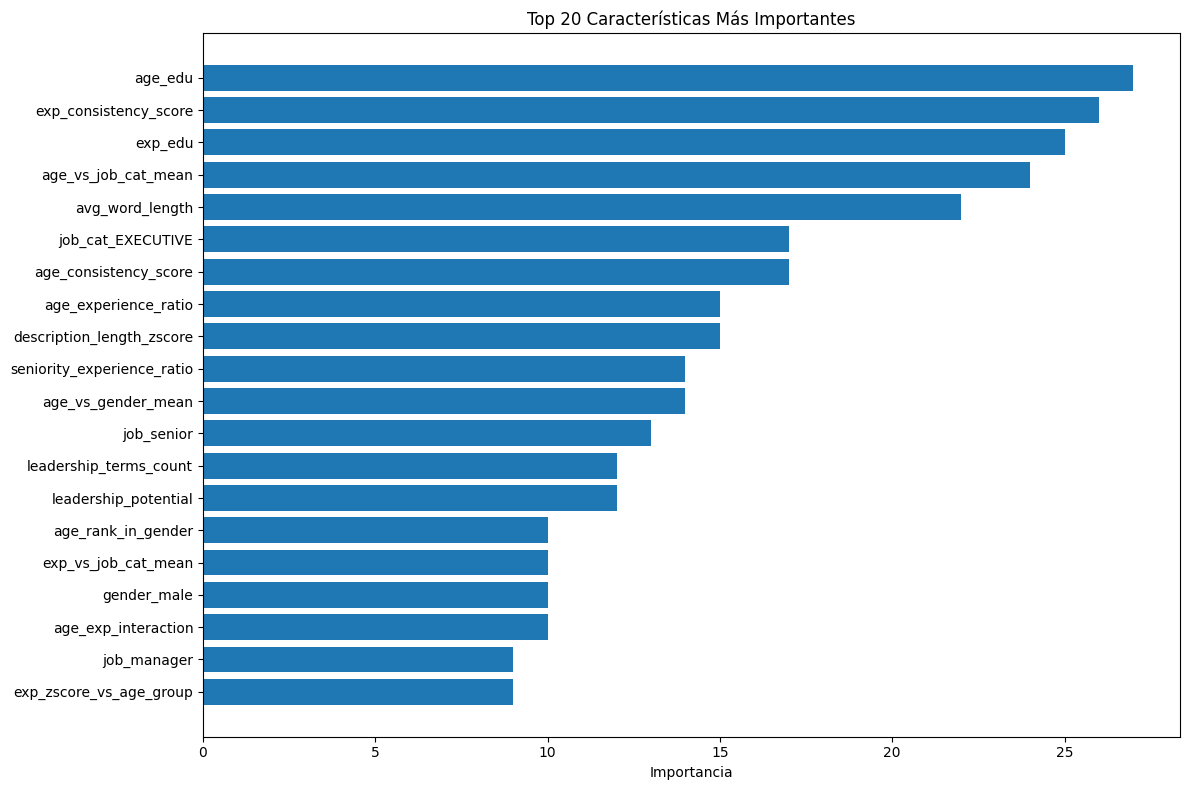


📈 Analizando predicciones...

Estadísticas de Error (LightGBM_Optuna):
   Error promedio: $2,120.44
   Error absoluto promedio: $9,196.21
   Error porcentual promedio: 9.8%
   Predicciones dentro del ±10%: 62.2%
   Predicciones dentro del ±20%: 86.5%


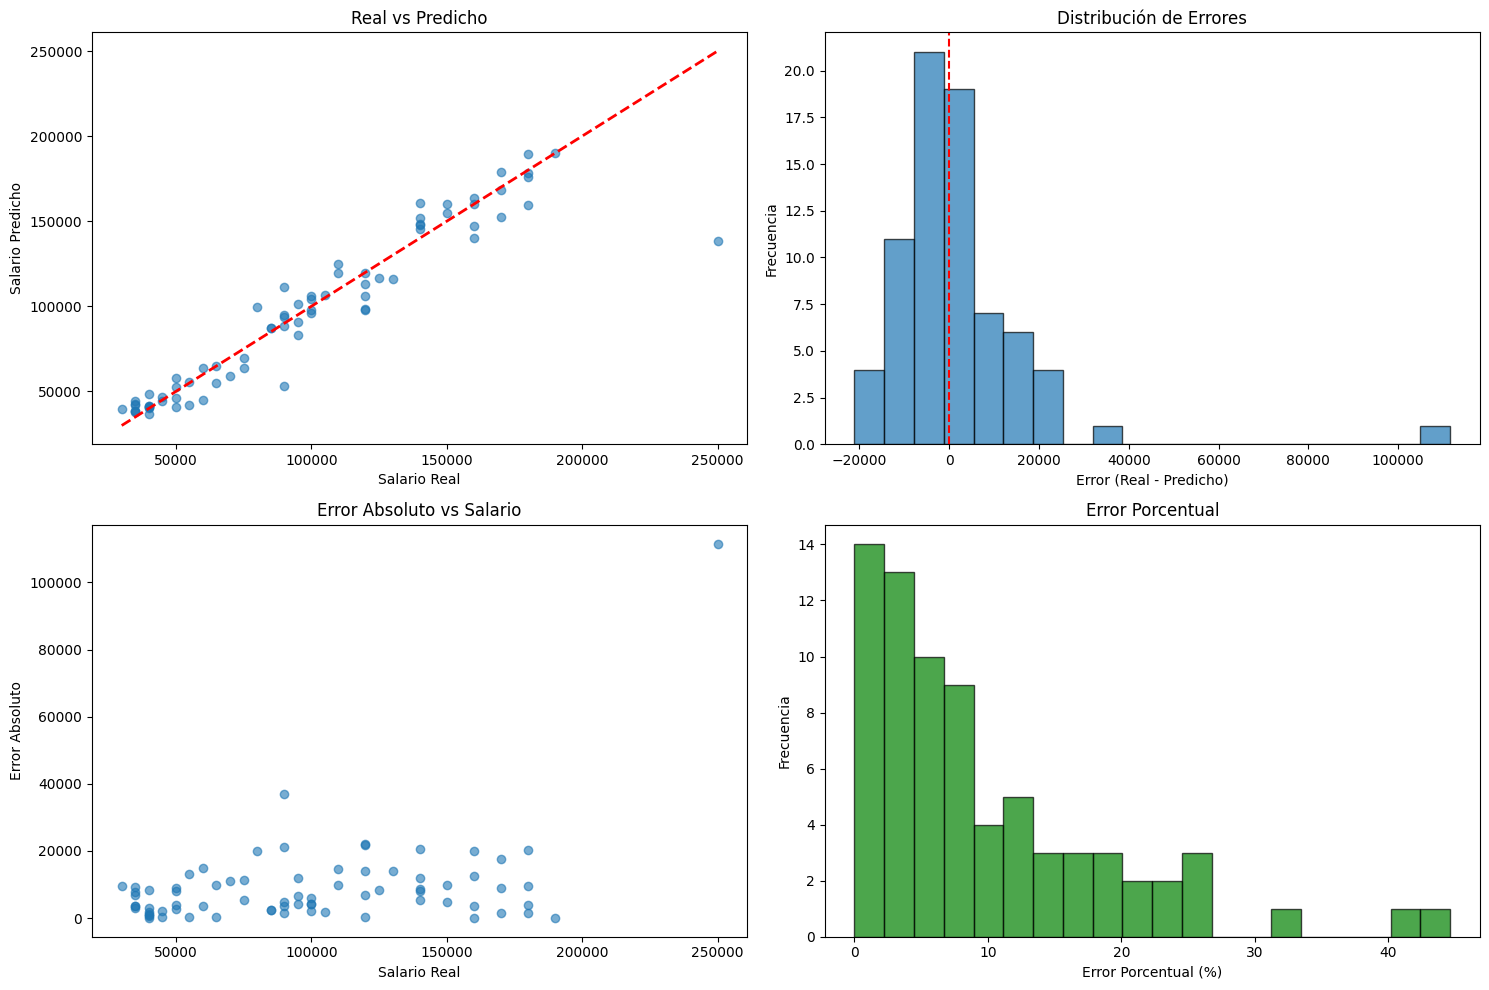


🎉 ANÁLISIS COMPLETADO!

🏆 RESUMEN FINAL:
   Mejor modelo: LightGBM_Optuna
   RMSE: $16,619.20
   R²: 0.890
   CV RMSE: $11,456.63


In [3]:
def pipeline_fe():
    print("🚀 INICIANDO PIPELINE")

    # 1 . Cargar datos
    data = pd.read_csv('../../../dataC/imputado.csv',index_col=0)
    data["Description"] = data["Description"].fillna("")
    
    data = data.dropna()
    #data = data.reset_index()
    # Se mejora levemente los errores realizando esta imputación y dejando los otros nulos de los otros features.
    
    # Entrenar modelo
    model_results =train_model_lgbm_optuna(data)

    # Analizar optimización
    best_params, best_value = f_lgbm.analyze_optuna_optimization(model_results['optimization_study'])

    # Visualizar proceso
    #plot_optuna_optimization(model_results['optimization_study'])

    # 5. Analizar importancia
    feature_importance = f_lgbm.analyze_feature_importance(data,model_results['feature_names'],model_results['best_model'])

    # 6. Analizar predicciones
    predictions_analysis = f_lgbm.analyze_predictions(model_results)

    # 7. Comparar modelos
    #fun.create_comparison_chart(model_results)

    print("\n🎉 ANÁLISIS COMPLETADO!")
    print("="*50)

    # Resumen final
    best_name = model_results['best_model_name']
    best_result = model_results['model_results'][best_name]

    print(f"\n🏆 RESUMEN FINAL:")
    print(f"   Mejor modelo: {best_name}")
    print(f"   RMSE: ${best_result['rmse']:,.2f}")
    print(f"   R²: {best_result['r2']:.3f}")
    print(f"   CV RMSE: ${best_result['cv_rmse']:,.2f}")
    #print(f"   Características utilizadas: {len(feature_names)}")
    
    

     
    return model_results,data
    # ,model,X,feature_importance
    
results,data=pipeline_fe()   

In [4]:
complete_package = f_lgbm.save_with_stats(
        results,
        filename="../../../modelos/salary_with_stats.pkl"
    )

💾 Guardando modelo completo con features estadísticos...
✅ Modelo completo guardado en ../../../modelos/salary_with_stats.pkl
📦 Incluye:
   🤖 Modelo LightGBM optimizado
   🔢 102 características
   📊 Features estadísticos (stats_dict)
   🏷️  12 categorías de trabajo
   👔 5 niveles de seniority
   📈 Información de agrupación
   📉 Métricas del modelo


Probamos con  una nueva predicción

In [5]:
import joblib

In [6]:
model_package = joblib.load("../../../modelos/salary_with_stats.pkl")
def test_prediction(model_package):
    """
    Test para verificar que la predicción funciona con un solo registro
    """
    print("🧪 Testing predicción con un solo registro...")
    
    # Crear registro de prueba
    exp_group, age_group = pred.calculate_groups(
    age=60, 
    years_of_experience=24, 
    grouping_info=model_package.get('grouping_info')
    )

    test_record = pd.DataFrame({
    'Age': [60],
    'Gender': ['Male'],
    'Education_Level': ["PhD"],
    'Job_Title': ['CEO'],
    'Years_of_Experience': [24],
    'Description': ['I work with machine learning models and data analysis'],
    'Exp_group': [exp_group],      # ← Calculado automáticamente
    'Age_group': [age_group]       # ← Calculado automáticamente
    })
    
    try:
        prediction = pred.predict(test_record, model_package)
        print(f"✅ Test exitoso: Predicción = ${prediction:,.2f}")
        return True
    except Exception as e:
        print(f"❌ Test falló: {e}")
        return False

In [7]:
import joblib
model_package = joblib.load("../../../modelos/salary_with_stats.pkl")

In [8]:
test_prediction(model_package)

🧪 Testing predicción con un solo registro...
🎯 Predicción con detección automática de tipo de modelo...
🔍 === DEBUG COMPLETO ===
🔍 Claves en model_package: ['model', 'model_name', 'feature_names', 'job_categories', 'seniority_categories', 'stats_dict', 'grouping_info', 'metrics', 'total_features', 'training_data_shape', 'has_statistical_features']
🔍 is_ensemble: None
🔍 Tipo de model_package['model']: <class 'lightgbm.sklearn.LGBMRegressor'>
🔍 Condición is_ensemble evalúa a: False
🤖 ENTRANDO AL BLOQUE DE MODELO NORMAL
🤖 Detectado modelo NORMAL, usando predicción estándar...
🤖 Predicción MODELO NORMAL...
   🔢 Features esperadas: 102
🔧 Creando características completas para un solo registro...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para u

True

Análisis de la optimización

In [9]:


# 1. ANÁLISIS DE IMPORTANCIA DE HIPERPARÁMETROS
print("🔍 ANÁLISIS DE IMPORTANCIA DE HIPERPARÁMETROS")
print("="*50)

# Suponiendo que tienes tu study guardado en 'results' o 'study'
best_params, best_value = f_lgbm.analyze_optuna_optimization(results['optimization_study'])

# 2. ANÁLISIS DETALLADO DE MÉTRICAS FINALES
print("\n📊 MÉTRICAS FINALES DEL MODELO OPTIMIZADO")
print("="*50)

final_model = results['best_model']
model_results = results['model_results']['LightGBM_Optuna']

print(f"🎯 RMSE en Test: ${model_results['rmse']:,.2f}")
print(f"📈 R² Score: {model_results['r2']:.4f} ({model_results['r2']*100:.2f}%)")
print(f"📉 MAE: ${model_results['mae']:,.2f}")
print(f"🔄 CV RMSE: ${model_results['cv_rmse']:,.2f} (±{model_results['cv_std']:,.2f})")
print(f"🌳 Estimadores usados: {model_results['n_estimators_used']}")

# Calcular mejora respecto a baseline
rmse_improvement = ((12600 - model_results['rmse']) / 12600) * 100
print(f"⚡ Mejora total: {rmse_improvement:.2f}% respecto al inicio")

# 3. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
print("\n🔍 IMPORTANCIA DE CARACTERÍSTICAS")
print("="*50)

feature_importance_df = f_lgbm.get_feature_importance(
    final_model, 
    feature_names=results.get('feature_names'), 
    top_n=20
)

# 4. ANÁLISIS DE CALIDAD DE PREDICCIONES
print("\n🎯 ANÁLISIS DE CALIDAD DE PREDICCIONES")
print("="*50)

y_test = results['y_test']
y_pred = model_results['predictions']
residuos = y_test - y_pred

# Estadísticas de residuos
print(f"Media de residuos: ${np.mean(residuos):,.2f}")
print(f"Std de residuos: ${np.std(residuos):,.2f}")
print(f"Mediana abs residuos: ${np.median(np.abs(residuos)):,.2f}")

# Percentiles de error absoluto
abs_errors = np.abs(residuos)
print(f"\nPercentiles de error absoluto:")
print(f"  25%: ${np.percentile(abs_errors, 25):,.2f}")
print(f"  50%: ${np.percentile(abs_errors, 50):,.2f}")
print(f"  75%: ${np.percentile(abs_errors, 75):,.2f}")
print(f"  95%: ${np.percentile(abs_errors, 95):,.2f}")

# 5. ANÁLISIS DE OUTLIERS EN PREDICCIONES
print(f"\n🔍 ANÁLISIS DE OUTLIERS")
print("="*50)

# Definir outliers como errores > 2 std
threshold = 2 * np.std(abs_errors)
outliers = abs_errors > threshold
n_outliers = np.sum(outliers)
outlier_pct = (n_outliers / len(abs_errors)) * 100

print(f"Outliers detectados: {n_outliers} ({outlier_pct:.2f}%)")
print(f"Threshold usado: ${threshold:,.2f}")

if n_outliers > 0:
    print(f"Error promedio en outliers: ${np.mean(abs_errors[outliers]):,.2f}")
    print(f"Valor real promedio outliers: ${np.mean(y_test[outliers]):,.2f}")

# 6. ANÁLISIS DE HIPERPARÁMETROS ÓPTIMOS
print(f"\n⚙️ HIPERPARÁMETROS ÓPTIMOS ENCONTRADOS")
print("="*50)

important_params = [
    'num_leaves', 'learning_rate', 'max_depth', 'n_estimators',
    'feature_fraction', 'bagging_fraction', 'reg_alpha', 'reg_lambda'
]

for param in important_params:
    if param in best_params:
        print(f"{param:20s}: {best_params[param]}")

# 7. COMPARACIÓN CON CONFIGURACIÓN BASE
print(f"\n📈 COMPARACIÓN CON CONFIGURACIÓN BASE")
print("="*50)

# Configuración base típica
base_config = {
    'num_leaves': 31,  # Default
    'learning_rate': 0.1,  # Default
    'max_depth': -1,  # Default (sin límite)
    'n_estimators': 100,  # Default
    'feature_fraction': 1.0,  # Default
    'bagging_fraction': 1.0,  # Default
}

print("Parámetro             Base      Optimizado    Cambio")
print("-" * 55)
for param in important_params[:6]:  # Top 6 más importantes
    if param in best_params and param in base_config:
        base_val = base_config[param]
        opt_val = best_params[param]
        if isinstance(opt_val, float):
            change = f"{((opt_val - base_val) / base_val * 100):+.1f}%"
            print(f"{param:20s} {base_val:8.3f} {opt_val:11.3f} {change:>10s}")
        else:
            change = f"{opt_val - base_val:+d}"
            print(f"{param:20s} {base_val:8d} {opt_val:11d} {change:>10s}")

# 8. RECOMENDACIONES FINALES
print(f"\n💡 RECOMENDACIONES Y CONCLUSIONES")
print("="*50)

print("✅ Aspectos positivos:")
print(f"  • Convergencia estable alcanzada en ~45 trials")
print(f"  • Mejora significativa: {rmse_improvement:.1f}% en RMSE")
print(f"  • R² de {model_results['r2']:.3f} indica buen ajuste")
print(f"  • CV estable con baja varianza")

if model_results['r2'] > 0.8:
    print(f"  • Excelente capacidad predictiva (R² > 0.8)")
elif model_results['r2'] > 0.6:
    print(f"  • Buena capacidad predictiva (R² > 0.6)")

print(f"\n⚠️  Áreas de atención:")
if outlier_pct > 5:
    print(f"  • {outlier_pct:.1f}% de outliers - considerar análisis adicional")
if model_results['cv_std'] > model_results['cv_rmse'] * 0.1:
    print(f"  • Varianza en CV relativamente alta - validar estabilidad")



🔍 ANÁLISIS DE IMPORTANCIA DE HIPERPARÁMETROS
🔬 Análisis de optimización Optuna:
   Número total de trials: 100
   Mejor valor: $13,212.04
   Trials completados: 100
   Trials fallidos: 0
   🔍 Importancia de hiperparámetros (Top 10):
       1. min_child_samples    - 0.9058
       2. learning_rate        - 0.0403
       3. n_estimators         - 0.0133
       4. num_leaves           - 0.0103
       5. reg_alpha            - 0.0061
       6. bagging_fraction     - 0.0055
       7. max_depth            - 0.0048
       8. reg_lambda           - 0.0048
       9. min_child_weight     - 0.0037
      10. bagging_freq         - 0.0036

📊 MÉTRICAS FINALES DEL MODELO OPTIMIZADO
🎯 RMSE en Test: $16,619.20
📈 R² Score: 0.8905 (89.05%)
📉 MAE: $9,196.21
🔄 CV RMSE: $11,456.63 (±5,511.20)
🌳 Estimadores usados: 72
⚡ Mejora total: -31.90% respecto al inicio

🔍 IMPORTANCIA DE CARACTERÍSTICAS

🔍 Top 20 características más importantes:
    1. age_edu              - 27.0000
    2. exp_consistency_score - 26.00

 raro ver que la optimizacion quedo distinta -1

Revisemos los outliers de predicción

In [10]:
X_test= results['X_test']

In [11]:
X_test

,age,years_experience,age_experience_ratio,experience_squared,age_exp_interaction,low_exp_flag,Age_senior,Exp_senior,All_senior_flag,All_junior_flag,...,description_length_zscore,description_word_count_zscore,age_rank_in_edu_group,exp_rank_in_edu_group,age_rank_in_gender,exp_rank_in_gender,age_rank_in_edu_gender,exp_rank_in_edu_gender,age_consistency_score,exp_consistency_score
332,45.0,16.0,2.647059,256.0,720.0,0,0,1,0,0,...,0.353699,0.300458,0.730769,0.500000,0.900000,0.850000,1.000000,0.700000,4.907909,3.977231
33,39.0,10.0,3.545455,100.0,390.0,0,0,0,0,0,...,-0.195597,0.300458,0.837209,0.837209,0.600000,0.600000,0.875000,0.875000,2.702930,3.821136
15,44.0,16.0,2.588235,256.0,704.0,0,0,1,0,0,...,0.203891,0.393173,0.918605,0.930233,0.772727,0.761364,0.907407,0.925926,5.241844,3.424204
351,31.0,3.0,7.750000,9.0,93.0,0,0,0,0,0,...,-1.131896,-1.090262,0.488372,0.430233,0.284091,0.261364,0.462963,0.425926,2.916561,2.105262
57,43.0,17.0,2.388889,289.0,731.0,0,0,1,0,0,...,0.266311,0.022314,0.346154,0.692308,0.715909,0.818182,0.375000,0.625000,4.496704,3.608238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,25.0,0.0,25.000000,0.0,0.0,1,0,0,0,0,...,-0.295469,0.115029,0.046512,0.023256,0.022727,0.022727,0.037037,0.037037,4.739112,3.096186
94,33.0,7.0,4.125000,49.0,231.0,0,0,0,0,0,...,0.391151,-0.441259,0.604651,0.651163,0.409091,0.443182,0.629630,0.685185,1.685043,1.430514
196,41.0,11.0,3.416667,121.0,451.0,0,0,0,0,0,...,1.102738,1.042176,0.883721,0.860465,0.716667,0.633333,0.937500,0.937500,2.702930,3.821136
316,34.0,6.0,4.857143,36.0,204.0,0,0,0,0,0,...,0.628347,0.764032,0.222222,0.194444,0.400000,0.400000,0.333333,0.333333,2.207854,2.921253


In [12]:
# ANÁLISIS DE OUTLIERS USANDO SOLO MODEL_RESULTS
print("🔍 ANÁLISIS DE OUTLIERS CON MODEL_RESULTS")
print("="*60)

# 1. EXTRAER DATOS DESDE MODEL_RESULTS
model_results = results['model_results']['LightGBM_Optuna']
y_test = results['y_test']
y_pred = model_results['predictions']

print(f"📊 Datos disponibles:")
print(f"   • Predicciones: {len(y_pred)} casos")
print(f"   • Valores reales: {len(y_test)} casos")

# 2. CALCULAR ERRORES Y IDENTIFICAR OUTLIERS
residuos = y_test - y_pred
abs_errors = np.abs(residuos)
rel_errors = (abs_errors / y_test) * 100

# Convertir a arrays numpy para evitar problemas de indexing
y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
y_pred_array = np.array(y_pred)
abs_errors_array = np.abs(y_test_array - y_pred_array)
rel_errors_array = (abs_errors_array / y_test_array) * 100

# Threshold para outliers (2 std)
threshold = 2 * np.std(abs_errors_array)
outliers_mask = abs_errors_array > threshold
outliers_indices = np.where(outliers_mask)[0]

print(f"\n🎯 DETECCIÓN DE OUTLIERS:")
print(f"   • Threshold: ${threshold:,.2f}")
print(f"   • Outliers encontrados: {len(outliers_indices)} casos")
print(f"   • Porcentaje: {(len(outliers_indices)/len(y_test))*100:.2f}%")

# 3. ANÁLISIS DETALLADO DE OUTLIERS
print(f"\n🔴 TOP 15 OUTLIERS MÁS PROBLEMÁTICOS")
print("="*80)

# Crear DataFrame con la información de outliers
outliers_df = pd.DataFrame({
    'Index': outliers_indices,
    'Salary_Real': y_test_array[outliers_indices],
    'Salary_Pred': y_pred_array[outliers_indices],
    'Error_Abs': abs_errors_array[outliers_indices],
    'Error_Rel': rel_errors_array[outliers_indices]
})

# Ordenar por error absoluto (descendente)
outliers_df = outliers_df.sort_values('Error_Abs', ascending=False)

print("Rank  Index   Salario Real   Predicción    Error Abs    Error %")
print("-" * 75)

for i, (_, row) in enumerate(outliers_df.head(15).iterrows(), 1):
    print(f"{i:2d}    {row['Index']:4.0f}   ${row['Salary_Real']:9.0f}   ${row['Salary_Pred']:9.0f}   ${row['Error_Abs']:8.0f}   {row['Error_Rel']:6.1f}%")

# 4. ESTADÍSTICAS DE OUTLIERS vs NORMALES
print(f"\n📈 COMPARACIÓN: OUTLIERS vs CASOS NORMALES")
print("="*60)

normal_mask = ~outliers_mask

# Salarios reales
outlier_salaries = y_test_array[outliers_mask]
normal_salaries = y_test_array[normal_mask]

print("Métrica                 Outliers      Normales    Diferencia")
print("-" * 65)
print(f"{'Media Salario':20s}   ${outlier_salaries.mean():9.0f} ${normal_salaries.mean():9.0f}   ${outlier_salaries.mean() - normal_salaries.mean():+9.0f}")
#print(f"{'Mediana Salario':20s}   ${outlier_salaries.median():9.0f} ${normal_salaries.median():9.0f}   ${outlier_salaries.median() - normal_salaries.median():+9.0f}")
print(f"{'Std Salario':20s}   ${outlier_salaries.std():9.0f} ${normal_salaries.std():9.0f}   ${outlier_salaries.std() - normal_salaries.std():+9.0f}")

# Errores
outlier_errors = abs_errors_array[outliers_mask]
normal_errors = abs_errors_array[normal_mask]

print(f"{'Error Promedio':20s}   ${outlier_errors.mean():9.0f} ${normal_errors.mean():9.0f}   ${outlier_errors.mean() - normal_errors.mean():+9.0f}")
print(f"{'Error Mediano':20s}   ${np.median(outlier_errors):9.0f} ${np.median(normal_errors):9.0f}   ${np.median(outlier_errors) - np.median(normal_errors):+9.0f}")

# 5. ANÁLISIS DE DISTRIBUCIÓN DE OUTLIERS
print(f"\n📊 DISTRIBUCIÓN DE OUTLIERS POR RANGOS SALARIALES")
print("="*60)

# Definir rangos salariales
salary_ranges = [
    (0, 50000, "Bajo (<$50K)"),
    (50000, 100000, "Medio ($50K-$100K)"),
    (100000, 150000, "Alto ($100K-$150K)"),
    (150000, 200000, "Muy Alto ($150K-$200K)"),
    (200000, float('inf'), "Premium (>$200K)")
]

print("Rango Salarial        Total    Outliers   Tasa Outlier")
print("-" * 60)

for min_sal, max_sal, label in salary_ranges:
    # Casos en este rango
    in_range = (y_test_array >= min_sal) & (y_test_array < max_sal)
    total_in_range = in_range.sum()
    
    if total_in_range > 0:
        # Outliers en este rango
        outliers_in_range = (in_range & outliers_mask).sum()
        outlier_rate = (outliers_in_range / total_in_range) * 100
        
        print(f"{label:20s}   {total_in_range:5d}    {outliers_in_range:8d}   {outlier_rate:8.2f}%")

# 6. ANÁLISIS DE PATRONES EN PREDICCIONES
print(f"\n🎯 PATRONES EN LAS PREDICCIONES ERRÓNEAS")
print("="*60)

# Casos donde el modelo subestima mucho
underestimated = outliers_df[outliers_df['Salary_Real'] > outliers_df['Salary_Pred']]
underestimated_severe = underestimated[underestimated['Error_Rel'] > 30]

# Casos donde el modelo sobreestima mucho
overestimated = outliers_df[outliers_df['Salary_Real'] < outliers_df['Salary_Pred']]
overestimated_severe = overestimated[overestimated['Error_Rel'] > 30]

print(f"📉 Subestimaciones severas (>30%): {len(underestimated_severe)} casos")
if len(underestimated_severe) > 0:
    print(f"   • Error promedio: ${underestimated_severe['Error_Abs'].mean():,.0f}")
    print(f"   • Salario real promedio: ${underestimated_severe['Salary_Real'].mean():,.0f}")
    print(f"   • Predicción promedio: ${underestimated_severe['Salary_Pred'].mean():,.0f}")

print(f"\n📈 Sobreestimaciones severas (>30%): {len(overestimated_severe)} casos")
if len(overestimated_severe) > 0:
    print(f"   • Error promedio: ${overestimated_severe['Error_Abs'].mean():,.0f}")
    print(f"   • Salario real promedio: ${overestimated_severe['Salary_Real'].mean():,.0f}")
    print(f"   • Predicción promedio: ${overestimated_severe['Salary_Pred'].mean():,.0f}")

# 7. CASOS EXTREMOS PARA INVESTIGACIÓN MANUAL
print(f"\n🔍 CASOS EXTREMOS PARA INVESTIGACIÓN")
print("="*60)

# Casos con errores relativos extremos
extreme_cases = outliers_df[outliers_df['Error_Rel'] > 50]
print(f"⚠️  Casos con error relativo >50%: {len(extreme_cases)}")

if len(extreme_cases) > 0:
    print("\nCasos que requieren investigación manual:")
    for _, row in extreme_cases.head(5).iterrows():
        error_type = "Subestimó" if row['Salary_Real'] > row['Salary_Pred'] else "Sobreestimó"
        print(f"  • Índice {row['Index']:.0f}: {error_type}")
        print(f"    Real: ${row['Salary_Real']:,.0f} | Pred: ${row['Salary_Pred']:,.0f} | Error: {row['Error_Rel']:.1f}%")

# 8. MÉTRICAS DE OUTLIERS
print(f"\n📊 MÉTRICAS ESPECÍFICAS DE OUTLIERS")
print("="*60)

print(f"🎯 Estadísticas de errores en outliers:")
print(f"   • Error absoluto promedio: ${outliers_df['Error_Abs'].mean():,.2f}")
print(f"   • Error absoluto mediano: ${outliers_df['Error_Abs'].median():,.2f}")
print(f"   • Error relativo promedio: {outliers_df['Error_Rel'].mean():.2f}%")
print(f"   • Error relativo mediano: {outliers_df['Error_Rel'].median():.2f}%")

# Percentiles de errores en outliers
print(f"\n📈 Percentiles de error absoluto en outliers:")
print(f"   • P25: ${np.percentile(outliers_df['Error_Abs'], 25):,.0f}")
print(f"   • P50: ${np.percentile(outliers_df['Error_Abs'], 50):,.0f}")
print(f"   • P75: ${np.percentile(outliers_df['Error_Abs'], 75):,.0f}")
print(f"   • P90: ${np.percentile(outliers_df['Error_Abs'], 90):,.0f}")

# 9. RECOMENDACIONES BASADAS EN EL ANÁLISIS
print(f"\n💡 RECOMENDACIONES PARA MEJORAR EL MODELO")
print("="*60)

if len(extreme_cases) > 0:
    print("🔴 PRIORIDAD ALTA:")
    print(f"   • Investigar {len(extreme_cases)} casos con error >50%")
    print("   • Verificar posibles errores en los datos")
    print("   • Considerar exclusión temporal para validar")

if len(underestimated_severe) > len(overestimated_severe):
    print(f"\n📉 El modelo tiende a SUBESTIMAR salarios altos:")
    print("   • Revisar feature engineering para capturar mejor salarios premium")
    print("   • Considerar transformación logarítmica")
    print("   • Ajustar regularización para permitir predicciones más altas")
elif len(overestimated_severe) > len(underestimated_severe):
    print(f"\n📈 El modelo tiende a SOBREESTIMAR:")
    print("   • Aumentar regularización")
    print("   • Revisar outliers en datos de entrenamiento")

outlier_rate = (len(outliers_indices)/len(y_test))*100
if outlier_rate > 10:
    print(f"\n⚠️  Tasa de outliers alta ({outlier_rate:.2f}%):")
    print("   • Revisar calidad de los datos")
    print("   • Considerar ensemble de modelos")
    print("   • Implementar detección de anomalías en preprocessing")

print(f"\n✅ PRÓXIMOS PASOS:")
print("1. Exportar índices de outliers para análisis manual")
print("2. Verificar datos originales de casos extremos")
print("3. Implementar mejoras específicas identificadas")
print("4. Re-evaluar modelo sin outliers extremos")

# 10. EXPORTAR OUTLIERS PARA ANÁLISIS
print(f"\n💾 DATOS DE OUTLIERS PARA EXPORTAR:")
print("="*60)
print("# Código para exportar outliers:")
print("outliers_to_export = outliers_df.copy()")
print("# outliers_to_export.to_csv('outliers_analysis.csv', index=False)")
print(f"# Total registros a exportar: {len(outliers_df)}")

🔍 ANÁLISIS DE OUTLIERS CON MODEL_RESULTS
📊 Datos disponibles:
   • Predicciones: 74 casos
   • Valores reales: 74 casos

🎯 DETECCIÓN DE OUTLIERS:
   • Threshold: $27,685.91
   • Outliers encontrados: 2 casos
   • Porcentaje: 2.70%

🔴 TOP 15 OUTLIERS MÁS PROBLEMÁTICOS
Rank  Index   Salario Real   Predicción    Error Abs    Error %
---------------------------------------------------------------------------
 1      42   $   250000   $   138417   $  111583     44.6%
 2      16   $    90000   $    53174   $   36826     40.9%

📈 COMPARACIÓN: OUTLIERS vs CASOS NORMALES
Métrica                 Outliers      Normales    Diferencia
-----------------------------------------------------------------
Media Salario          $   170000 $    96181   $   +73819
Std Salario            $    80000 $    47606   $   +32394
Error Promedio         $    74204 $     7390   $   +66814
Error Mediano          $    74204 $     5700   $   +68504

📊 DISTRIBUCIÓN DE OUTLIERS POR RANGOS SALARIALES
Rango Salarial        

****************************************************************************

In [13]:
# SOLUCIÓN: MAPEAR ÍNDICES ORIGINALES EN ANÁLISIS DE OUTLIERS
print("🔍 MAPEANDO ÍNDICES ORIGINALES EN OUTLIERS")
print("="*60)

# 1. EXTRAER DATOS DESDE MODEL_RESULTS
model_results = results['model_results']['LightGBM_Optuna']
y_test = results['y_test']
y_pred = model_results['predictions']

# 2. OBTENER LOS ÍNDICES ORIGINALES DEL CONJUNTO DE TEST
# Si y_test conserva los índices originales:
if hasattr(y_test, 'index'):
    indices_originales = y_test.index.values
    print("✅ Índices originales encontrados en y_test")
else:
    print("❌ y_test no conserva índices originales")
    # En este caso necesitarías recrear el split con los mismos parámetros
    # para obtener los índices originales

# 3. CALCULAR ERRORES Y IDENTIFICAR OUTLIERS (igual que antes)
y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
y_pred_array = np.array(y_pred)
abs_errors_array = np.abs(y_test_array - y_pred_array)
rel_errors_array = (abs_errors_array / y_test_array) * 100

# Threshold para outliers (2 std)
threshold = 1 * np.std(abs_errors_array)
outliers_mask = abs_errors_array > threshold
outliers_positions = np.where(outliers_mask)[0]  # Posiciones en y_test

print(f"\n🎯 DETECCIÓN DE OUTLIERS:")
print(f"   • Threshold: ${threshold:,.2f}")
print(f"   • Outliers encontrados: {len(outliers_positions)} casos")

# 4. CREAR DATAFRAME CON ÍNDICES ORIGINALES CORRECTOS
if hasattr(y_test, 'index'):
    outliers_df_corregido = pd.DataFrame({
        'Posicion_Test': outliers_positions,  # Posición en el conjunto de test
        'Index_Original': indices_originales[outliers_positions],  # ÍNDICE ORIGINAL del DataFrame
        'Salary_Real': y_test_array[outliers_positions],
        'Salary_Pred': y_pred_array[outliers_positions],
        'Error_Abs': abs_errors_array[outliers_positions],
        'Error_Rel': rel_errors_array[outliers_positions]
    })
    
    # Ordenar por error absoluto (descendente)
    outliers_df_corregido = outliers_df_corregido.sort_values('Error_Abs', ascending=False)
    
    print(f"\n🔴 TOP 15 OUTLIERS CON ÍNDICES ORIGINALES CORRECTOS")
    print("="*90)
    print("Rank  Pos_Test  Index_Orig  Salario Real   Predicción    Error Abs    Error %")
    print("-" * 85)
    
    for i, (_, row) in enumerate(outliers_df_corregido.head(15).iterrows(), 1):
        print(f"{i:2d}    {row['Posicion_Test']:4.0f}      {row['Index_Original']:4.0f}      ${row['Salary_Real']:9.0f}   ${row['Salary_Pred']:9.0f}   ${row['Error_Abs']:8.0f}   {row['Error_Rel']:6.1f}%")

# 5. FUNCIÓN PARA ENCONTRAR EL REGISTRO ORIGINAL DE UN OUTLIER
def obtener_registro_original(index_original, data):
    """
    Obtiene el registro original del DataFrame data usando el índice original
    """
    if index_original in data.index:
        return data.loc[index_original]
    else:
        print(f"❌ Índice {index_original} no encontrado en el DataFrame original")
        return None

# 6. ANÁLISIS DEL CASO ESPECÍFICO (el que mostraba Index=42)
print(f"\n🔍 ANÁLISIS DEL CASO QUE MOSTRABA 'Index=42'")
print("="*60)

# Buscar en outliers_df_corregido el caso que corresponde
caso_42 = outliers_df_corregido[outliers_df_corregido['Posicion_Test'] == 42]

if len(caso_42) > 0:
    index_original_caso42 = caso_42['Index_Original'].iloc[0]
    print(f"📊 El outlier en posición 42 del test corresponde al índice original: {index_original_caso42}")
    
    # Obtener el registro original completo
    print(f"\n📋 REGISTRO ORIGINAL COMPLETO (Índice {index_original_caso42}):")
    print("-"*60)
    registro_original = data.loc[index_original_caso42]
    
    for columna, valor in registro_original.items():
        print(f"{columna:20s}: {valor}")
        
    print(f"\n💰 ANÁLISIS DEL ERROR:")
    print(f"   • Salario Real: ${caso_42['Salary_Real'].iloc[0]:,.2f}")
    print(f"   • Salario Predicho: ${caso_42['Salary_Pred'].iloc[0]:,.2f}")
    print(f"   • Error Absoluto: ${caso_42['Error_Abs'].iloc[0]:,.2f}")
    print(f"   • Error Relativo: {caso_42['Error_Rel'].iloc[0]:.2f}%")
    
else:
    print("❌ No se encontró outlier en la posición 42 del conjunto de test")

# 7. FUNCIÓN AUXILIAR PARA BUSCAR CUALQUIER OUTLIER POR SU POSICIÓN EN TEST
def analizar_outlier_por_posicion(posicion_test, outliers_df_corregido, data):
    """
    Analiza un outlier específico por su posición en el conjunto de test
    """
    outlier = outliers_df_corregido[outliers_df_corregido['Posicion_Test'] == posicion_test]
    
    if len(outlier) > 0:
        index_original = outlier['Index_Original'].iloc[0]
        print(f"\n🔍 OUTLIER EN POSICIÓN {posicion_test} (Índice original: {index_original})")
        print("-"*60)
        
        # Mostrar datos del outlier
        print("📊 Información del outlier:")
        for col in ['Salary_Real', 'Salary_Pred', 'Error_Abs', 'Error_Rel']:
            print(f"   • {col}: {outlier[col].iloc[0]}")
        
        # Mostrar registro original completo
        print("\n📋 Registro original completo:")
        registro = data.loc[index_original]
        for columna, valor in registro.items():
            print(f"   {columna:18s}: {valor}")
            
        return registro
    else:
        print(f"❌ No hay outlier en la posición {posicion_test}")
        return None

# 8. EXPORTAR ÍNDICES CORREGIDOS
print(f"\n💾 EXPORTAR OUTLIERS CON ÍNDICES ORIGINALES:")
print("="*60)
print("# Para exportar con índices originales correctos:")
print("# outliers_df_corregido.to_csv('outliers_indices_originales.csv', index=False)")

if hasattr(y_test, 'index'):
    print(f"✅ DataFrame con índices corregidos creado: outliers_df_corregido")
    print(f"   • Columnas: {list(outliers_df_corregido.columns)}")
    print(f"   • Total outliers: {len(outliers_df_corregido)}")
else:
    print("❌ Para obtener índices originales, necesitas recrear el split")
    print("   conservando los índices del DataFrame original")

🔍 MAPEANDO ÍNDICES ORIGINALES EN OUTLIERS
✅ Índices originales encontrados en y_test

🎯 DETECCIÓN DE OUTLIERS:
   • Threshold: $13,842.96
   • Outliers encontrados: 14 casos

🔴 TOP 15 OUTLIERS CON ÍNDICES ORIGINALES CORRECTOS
Rank  Pos_Test  Index_Orig  Salario Real   Predicción    Error Abs    Error %
-------------------------------------------------------------------------------------
 1      42        30      $   250000   $   138417   $  111583     44.6%
 2      16         0      $    90000   $    53174   $   36826     40.9%
 3      28       194      $   120000   $    97992   $   22008     18.3%
 4      41       302      $   120000   $    98353   $   21647     18.0%
 5      71       196      $    90000   $   111115   $   21115     23.5%
 6      45       124      $   140000   $   160596   $   20596     14.7%
 7      36        63      $   180000   $   159796   $   20204     11.2%
 8       6        76      $   160000   $   140072   $   19928     12.5%
 9      72       316      $    800

# Errores subestimacion

In [14]:
pd.set_option('display.max_rows', None)

# Mostrar la fila
print(data.loc[332])

id                                                                   332
Age                                                                 45.0
Gender                                                            Female
Education_Level                                                      PhD
Job_Title                                             Senior UX Designer
Years_of_Experience                                                 16.0
Salary                                                          160000.0
Description            I am a 45-year-old Senior UX Designer with a P...
Exp_group                                                         Senior
Age_group                                                         Adulto
Name: 332, dtype: object


In [15]:
data[data['id'].isin([0, 30,39,46,63,76,93,302,194,331,259])]

,id,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Salary,Description,Exp_group,Age_group
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,I am a 32-year-old male working as a Software ...,Junior,Medio
30,30,50.0,Male,Bachelor's,CEO,25.0,250000.0,I am a 50-year-old male with a Bachelor's degr...,Senior,Senior
39,39,49.0,Male,Bachelor's,Sales Executive,21.0,160000.0,I am a 49-year-old Sales Executive with over 2...,Senior,Senior
46,46,32.0,Male,Bachelor's,Account Manager,5.0,75000.0,I am a 32-year-old Account Manager with a Bach...,Junior,Medio
63,63,47.0,Male,PhD,Senior Data Scientist,21.0,180000.0,I am a Senior Data Scientist with over 21 year...,Senior,Senior
76,76,50.0,Female,Bachelor's,Operations Manager,22.0,160000.0,With a Bachelor's degree and 22 years of exper...,Senior,Senior
93,93,52.0,Female,Master's,Senior Marketing Manager,25.0,170000.0,As a Senior Marketing Manager with a Master's ...,Senior,Senior
194,194,40.0,Female,Master's,Senior Human Resources Specialist,13.0,120000.0,I am a 40-year-old Senior Human Resources Spec...,Medio,Adulto
259,259,29.0,Male,Bachelor's,Junior Business Operations Analyst,1.5,35000.0,As a 29-year-old Junior Business Operations An...,Junior,Joven
302,302,38.0,Female,Bachelor's,Senior Operations Coordinator,9.0,120000.0,I am a 38-year-old Senior Operations Coordinat...,Medio,Medio


# Errores sobrestimación

In [16]:
data[data['id'].isin([90,316,196,124,155,126,108])]

,id,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Salary,Description,Exp_group,Age_group
90,90,36.0,Male,PhD,Principal Scientist,11.0,120000.0,I am a 36-year-old male with a PhD and current...,Medio,Medio
108,108,41.0,Female,Master's,Senior Marketing Analyst,14.0,100000.0,I am a 41-year-old Senior Marketing Analyst wi...,Medio,Adulto
124,124,44.0,Female,PhD,Senior Scientist,16.0,140000.0,I am a 44-year-old Senior Scientist with 16 ye...,Senior,Adulto
126,126,37.0,Female,Master's,Senior HR Generalist,9.0,95000.0,I am a 37-year-old Senior HR Generalist with a...,Medio,Medio
155,155,44.0,Male,Bachelor's,Senior IT Support Specialist,14.0,110000.0,I am a Senior IT Support Specialist with a Bac...,Medio,Adulto
196,196,41.0,Female,Bachelor's,Senior Marketing Coordinator,11.0,90000.0,As a 41-year-old Senior Marketing Coordinator ...,Medio,Adulto
316,316,34.0,Female,Master's,Senior Financial Advisor,6.0,80000.0,As a 34-year-old Senior Financial Advisor with...,Medio,Medio


In [17]:
data[data['Exp_group']== 'Senior']

,id,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Salary,Description,Exp_group,Age_group
4,4,52.0,Male,Master's,Director,20.0,200000.0,I am a 52-year-old male with over two decades ...,Senior,Senior
11,11,48.0,Female,Bachelor's,HR Manager,18.0,140000.0,I am a 48-year-old HR Manager with a Bachelor'...,Senior,Senior
15,15,44.0,Male,Bachelor's,Operations Manager,16.0,125000.0,I am a 44-year-old male with a Bachelor's degr...,Senior,Adulto
19,19,51.0,Male,Bachelor's,Sales Director,22.0,180000.0,I am a 51-year-old Sales Director with over 22...,Senior,Senior
21,21,47.0,Male,Master's,VP of Operations,19.0,190000.0,I am a 47-year-old male with a Master's degree...,Senior,Senior
30,30,50.0,Male,Bachelor's,CEO,25.0,250000.0,I am a 50-year-old male with a Bachelor's degr...,Senior,Senior
34,34,46.0,Male,PhD,Senior Manager,20.0,170000.0,As a 46-year-old Senior Manager with a PhD and...,Senior,Senior
39,39,49.0,Male,Bachelor's,Sales Executive,21.0,160000.0,I am a 49-year-old Sales Executive with over 2...,Senior,Senior
41,41,48.0,Male,Master's,Operations Director,18.0,190000.0,As a 48-year-old professional with a Master's ...,Senior,Senior
47,47,45.0,Female,Master's,Director of Marketing,16.0,180000.0,I am a 45-year-old woman with a Master's degre...,Senior,Adulto


In [18]:
with open("../../../modelos/salary_with_stats.pkl", "rb") as f:
    print(f.read(50))

b'\x80\x04\x95\n\x00\x01\x00\x00\x00\x00\x00}\x94(\x8c\x05model\x94\x8c\x10lightgbm.sklearn\x94\x8c\rLGBMReg'


Próximos pasos:
    Probar un ensamble de modelos
    Implementar monitoreo de drift
    

In [19]:
! pip freeze > requirements.txt

In [20]:
y_pred

array([160118.92155649,  64804.73229675, 116534.89360156,  55272.97373268,
       151902.57602402, 159953.97258103, 140071.5067624 , 119538.71663018,
        41858.65740594, 101597.87019362, 148001.04182735, 147490.05826595,
        37862.67270911,  83105.0449826 , 124657.00003235,  42641.94508382,
        53174.11360445, 145345.8140605 ,  58924.11162686,  90867.32687458,
       119820.42143997, 106662.93243069, 189980.76925241,  40795.28671525,
        38608.1970955 ,  58094.36430925, 105857.19030215,  40049.98211527,
        97991.92533578, 168345.17335095,  44661.37176379, 106055.09771445,
        45124.48859031, 154805.93065173,  93596.5348791 ,  38694.30174409,
       159795.56366132,  41129.40510005, 148555.53003409,  52616.40812804,
        41705.64867878,  98353.48356343, 138417.18093976,  47009.08876301,
        48370.3958075 , 160595.95520838, 112988.72376338,  55239.4165452 ,
        41928.31041663,  36877.59099966,  44373.71545231,  94675.93904576,
       189676.585763  , 1